# Lab 1 - BCC406

## REDES NEURAIS E APRENDIZAGEM EM PROFUNDIDADE

## Regressão Linear

### Prof. Eduardo e Prof. Pedro

Objetivos:

- Regressão e Descida do Gradiente

Data da entrega : 19/08 

- Complete o código (marcado com ToDo) e quando requisitado, escreva textos diretamente nos notebooks. Onde tiver *None*, substitua pelo seu código.
- Execute todo notebook e salve tudo em um PDF **nomeado** como "NomeSobrenome-LabX.pdf"
- Envie o PDF via google [FORM](https://forms.gle/vXrTeKVNB6HnpUGfA)


# Regressão e Descida do Gradiente (100pt)

Neste estudo dirigido, resolveremos um problema de regressão, usando algoritmos da descida do gradiente para otimização dos pesos. Vamos implementar a descida do gradiente tradicional e uma versão estocástica com mini-lotes.

Vamos aplicar em um problema de predição de preços de casas (**California Housing Dataset**)

## Regressão (10pt)

### Importando as bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error

np.random.seed(150794)

A biblioteca [Scikit-learn](https://scikit-learn.org/stable/) é focada em aprendizagem de máquina e fornece diversos métodos de classificação, extração de características, etc. Ela também fornece algumas bases de dados clássicas, por meio de objetos do Pandas.

Se você não conhece o pacote Pandas, veja este [curso rápido](https://www.kaggle.com/learn/pandas).

### Carregando os dados

In [2]:
housing_data = fetch_california_housing()

Features = pd.DataFrame(housing_data.data, columns=housing_data.feature_names)
Target = pd.DataFrame(housing_data.target, columns=['Target'])

df = Features.join(Target)

### Entendendo os dados

Vamos usar apenas uma característica, renda média (MedInc), como variável independente e o preço final como variável dependente.

In [8]:
df[['MedInc', 'Target']].describe()

,MedInc,Target
count,14653.000000,14653.000000
mean,3.040936,1.516223
std,0.979781,0.614151
min,0.499900,0.149990
25%,2.281300,1.006000
50%,3.034100,1.478000
75%,3.796900,1.931000
max,4.998400,2.993000


**Resultado esperado (não precisa ser idêntico)**

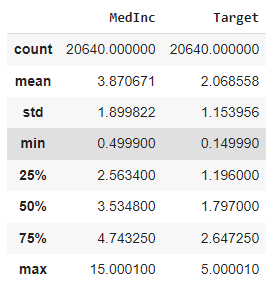

### Pré-processamento

#### Removendo outlier

Perceba que em 75% dos dados, a renda média (MedInc) é menor que 5 e que o valor da casa (Target) é menor que 3. Vamos remover rendas maiores que 5 e casas com preço maior que 3, para evitar valores espúrios e outliers.

In [9]:
df = df[df.MedInc < 5]
df = df[df.Target < 3]

#### Normalização

Também vamos deixar as duas variáveis na faixa entre 0 e 1 

In [5]:
def scale(x):
    min = x.min()
    max = x.max()
    return pd.Series([(i - min)/(max - min) for i in x])

X = scale(df.MedInc)
y = scale(df.Target)

In [11]:
#conferindo o valor máximo 
X.max(), y.max()

(1.0, 1.0)

Valor esperado: (1.0, 1.0)

#### Plotando os dados

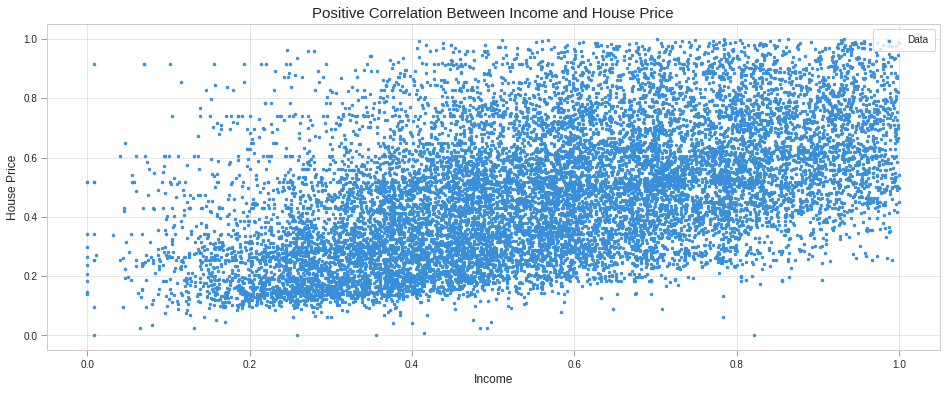

In [7]:
plt.figure(figsize=(16,6))
plt.rcParams['figure.dpi'] = 227
plt.style.use('seaborn-whitegrid')
plt.scatter(X, y, label='Data', c='#388fd8', s=6)
plt.title('Positive Correlation Between Income and House Price', fontSize=15)
plt.xlabel('Income', fontSize=12)
plt.ylabel('House Price', fontSize=12)
plt.legend(frameon=True, loc=1, fontsize=10, borderpad=.6)
plt.tick_params(direction='out', length=6, color='#a0a0a0', width=1, grid_alpha=.6)
plt.show()

**Resultado esperado (não precisa ser idêntico)**
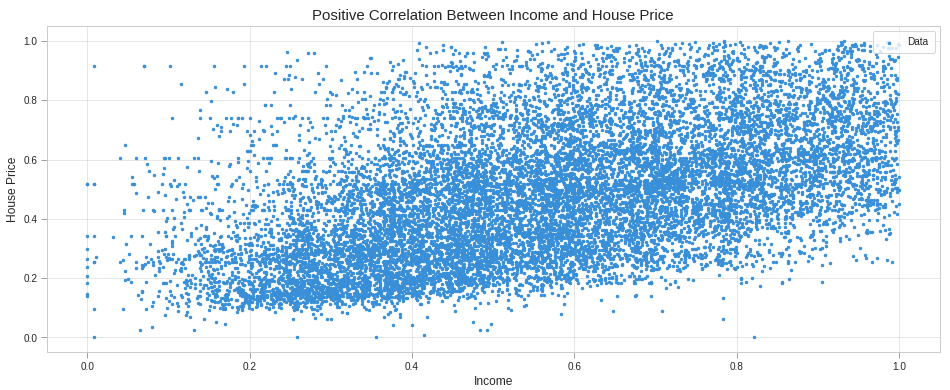

### **ToDo**: Discussão (10pt)

Por que os dados devem ser normalizados entre 0 e 1 ?

```
  O objetivo da normalização é alterar os valores das colunas numéricas no conjunto de dados para uma escala comum (neste caso entre 0 e 1), sem distorcer as diferenças nos intervalos de valores. Esse método é necessário quando o intervalo entre os dados entre os dados são muito diferentes, pois isso pode afetar o desempenho dos algoritmos utilizados pelas redes neurais (uma regressão logística multivariada, por exemplo). Se um atributo estiver com um intervalo(amplitude) muito grande, o peso associado a ele será muito grande, e isso significa que uma pequena variação no coeficiente do mesmo gerará uma variação muito grande do resultado da algoritmo de otimização (descida do gradiente, por exemplo). Portanto, a normalização ajuda a contornar esse problema.
```

## Descida do gradiente (90pt)

Vamos resolver uma regressão linear, de uma única característica - MedInc -  (vetor de pesos tem uma dimensão), do tipo $Y = mX + b$, e usar erro quadrático médio (mean squared error) como funçào objetivo para a descida do gradiente.

![MSE](https://drive.google.com/uc?export=view&id=1XrK7UrWYdKk2iMgnDPmTMtYbpX44mULB)

considerando y chapéu como saída do nosso modelo e y como o rótulo. Expandindo a função é : 

![exp](https://drive.google.com/uc?export=view&id=1g_xl-nAjSpzBa-ee6k0rLX5xNF6QlQH-)

Derivada em relação a m :

![derm](https://drive.google.com/uc?export=view&id=1UYon6FpnwGD3oLS9-Sx5tOunRBI1dagM)

Derivada em relação a b :

![derb](https://drive.google.com/uc?export=view&id=1ukBveq7BRl7sV2NE__sXnminbpiRrQqd)

### **ToDo**: Função da descida do gradiente e para plotar a regressão (30pts)

Vamos implementar uma função chamada *gradient_descent*, seguindo alguns passos:

  1.   Inicializar m e b aleatoriamente (entre 0 e 1)
  2.   Iterar por um número de épocas (*epoch*)
  3.   A cada iteração, calcular o valor predito, o erro quadrático entre o valor predito e $y$, atualizar os valores de m e b no sentido contrário do gradiente (o ajuste deve ser controlado por um taxa de aprendizado - *Learning Rate (lr)*).
  4.   Armazenar m, b e erro corrente para análise futura

In [35]:
def gradient_descent(X, y, lr=0.05, epoch=10):
    
    '''
    Descida do Gradiente
    '''

    m, b = np.random.uniform(), np.random.uniform() # ToDo : inicialize aleatoriamente entre 0 e 1
    
    log, mse_log = [], [] # listas para armazenar o processo de aprendizado
    N = len(X) # número de instâncias total do conjunto
    
    for e in range(epoch):
        
        predict = m*X + b # ToDo : propague (feed-forward) ara obter as predições : m*X + b
        MSE = (1/N)*(sum((y-predict)**2)) # ToDo : calcule o erro quadrático médio, conforme equação acima
        
        f = (1/N)*(sum((y-(m*X +b ))**2)) # ToDo : compute a derivada 
        
        # atualize m e b
        m -= (1/N)*(sum((-2)*X*(y-(m*X +b )))) # ToDo : atualize m com base na equação acima. Lembre-se de ponderar pela taxa de aprendizado (lr)
        b -= (1/N)*(sum((-2)*(y-(m*X +b )))) # ToDo : atualize b com base na equação acima. Lembre-se de ponderar pela taxa de aprendizado (lr)
        
        # armazena para uso futuro
        log.append((m, b))
        mse_log.append(MSE)        
    
    return m, b, log, mse_log

In [36]:
def plot_regression(X, y, y_pred, log=None, title="Linear Regression"):
    
    plt.figure(figsize=(16,6))
    plt.rcParams['figure.dpi'] = 227
    plt.scatter(X, y, label='Data', c='#388fd8', s=6)
    if log != None:
        for i in range(len(log)):
            plt.plot(X, log[i][0]*X + log[i][1], lw=1, c='#caa727', alpha=0.15)
    plt.plot(X, y_pred, c='#ff7702', lw=3, label='Regressao')
    plt.title(title, fontSize=14)
    plt.xlabel('Renda', fontSize=11)
    plt.ylabel('Preço', fontSize=11)
    plt.legend(frameon=True, loc=1, fontsize=10, borderpad=.6)
    plt.tick_params(direction='out', length=6, color='#a0a0a0', width=1, grid_alpha=.6)
    plt.show()

MSE: 0.03467085249585766


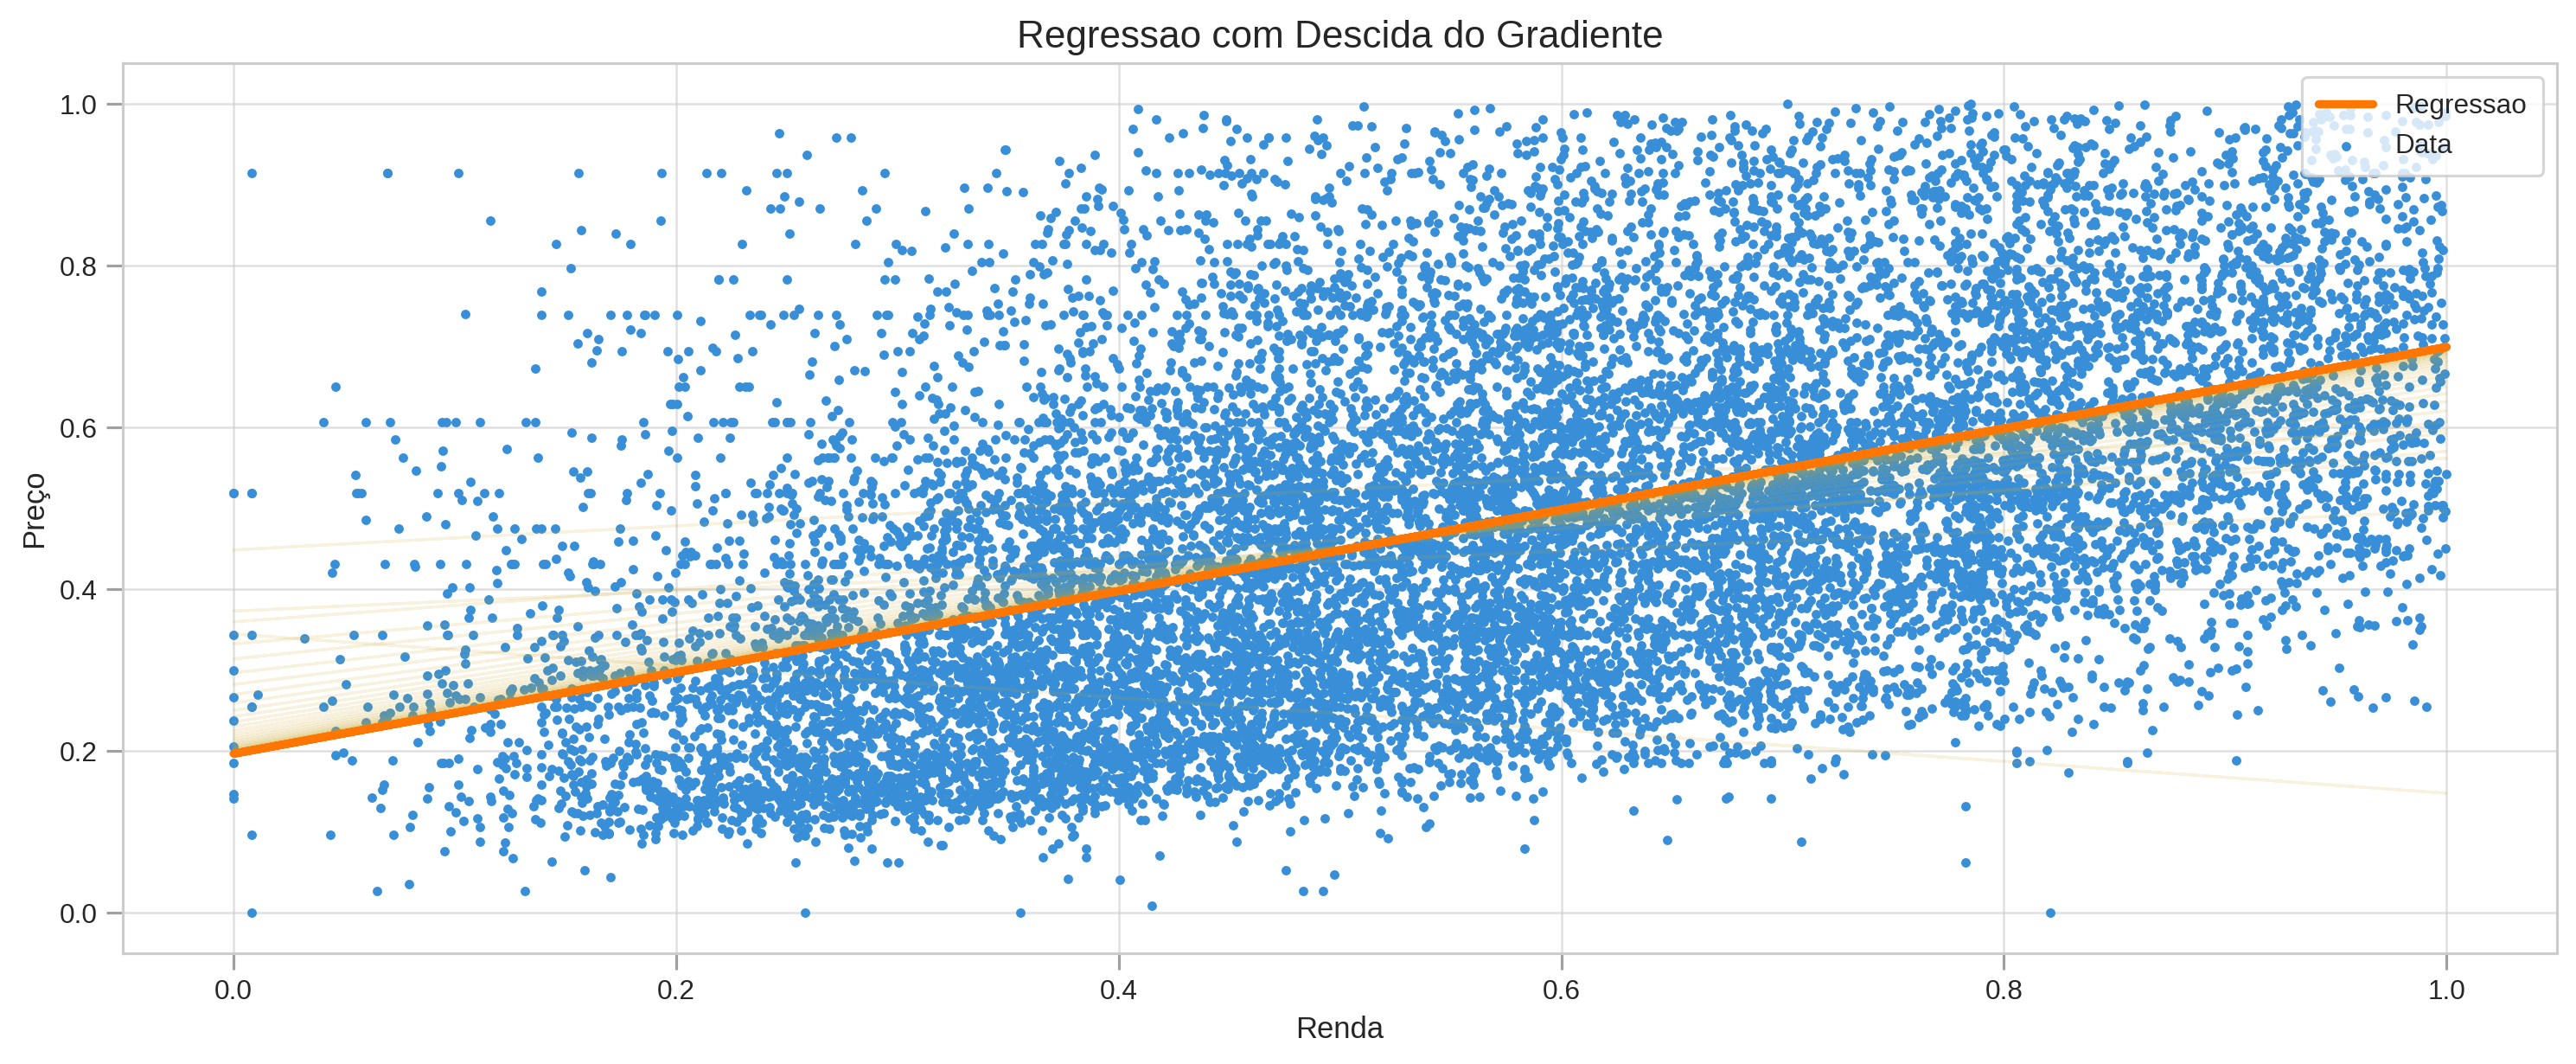

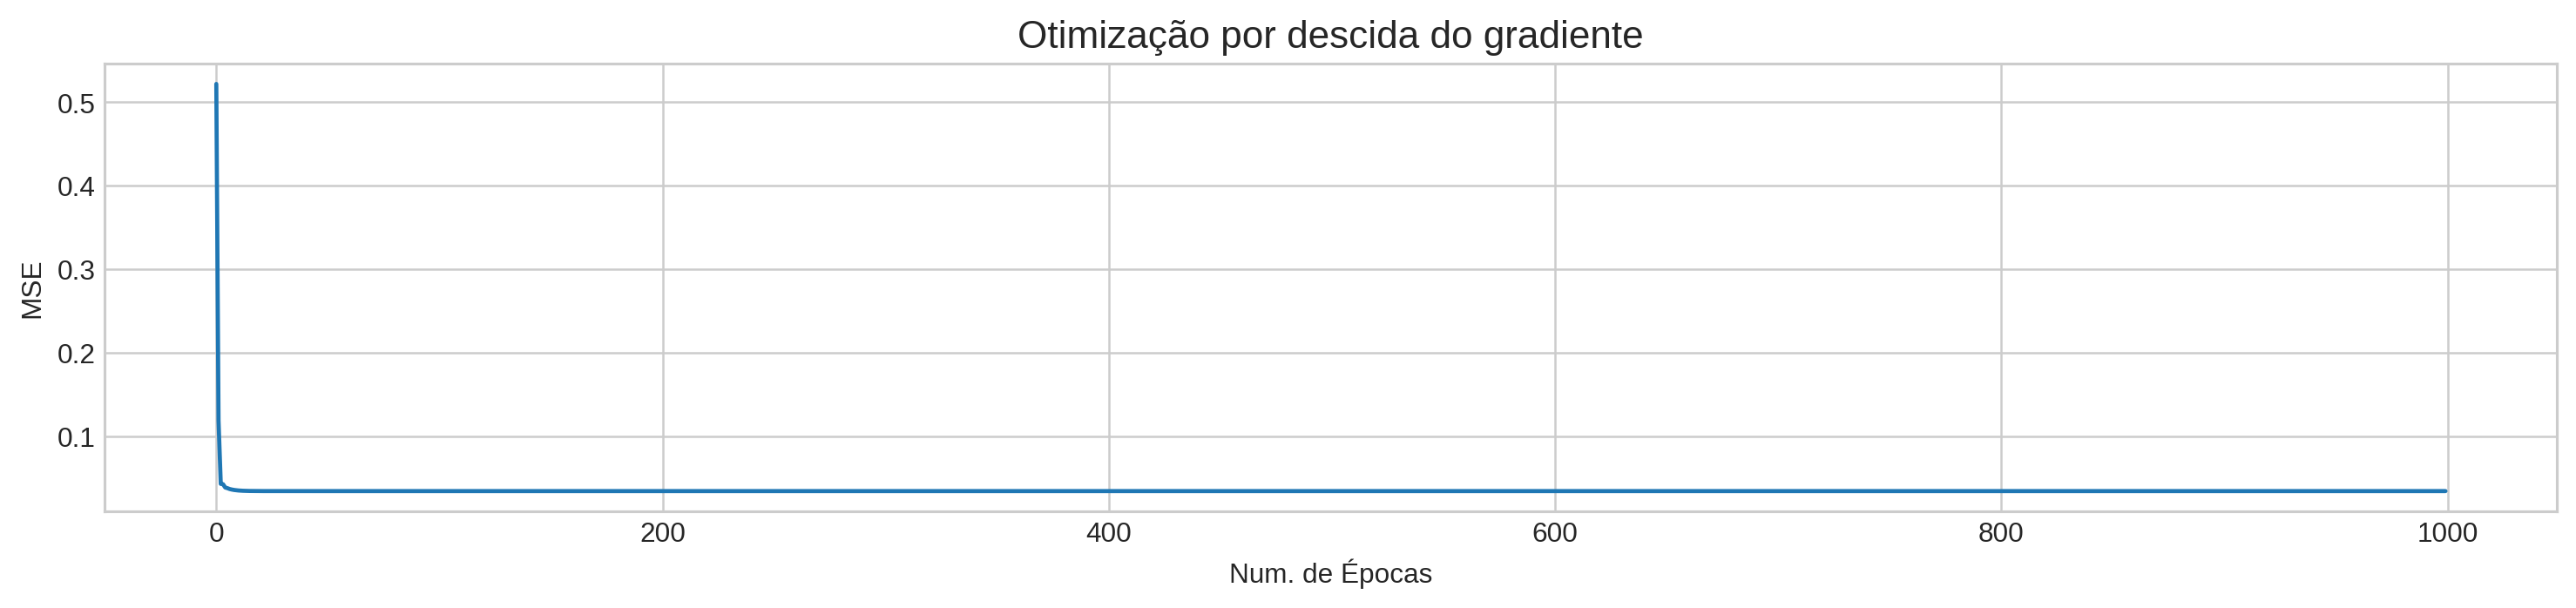

In [37]:
m, b, log1, mse1 = gradient_descent(X, y, lr=0.01, epoch=1000)

y_pred = m*X + b

print("MSE:",mean_squared_error(y, y_pred))
plot_regression(X, y, y_pred, log=log1, title="Regressao com Descida do Gradiente")

plt.figure(figsize=(16,3))
plt.rcParams['figure.dpi'] = 227
plt.plot(range(len(mse1)), mse1)
plt.title('Otimização por descida do gradiente', fontSize=14)
plt.xlabel('Num. de Épocas')
plt.ylabel('MSE')
plt.show()

**Resultados eperados (não precisa ser idêntico)**

```MSE: 0.034740339862818236```

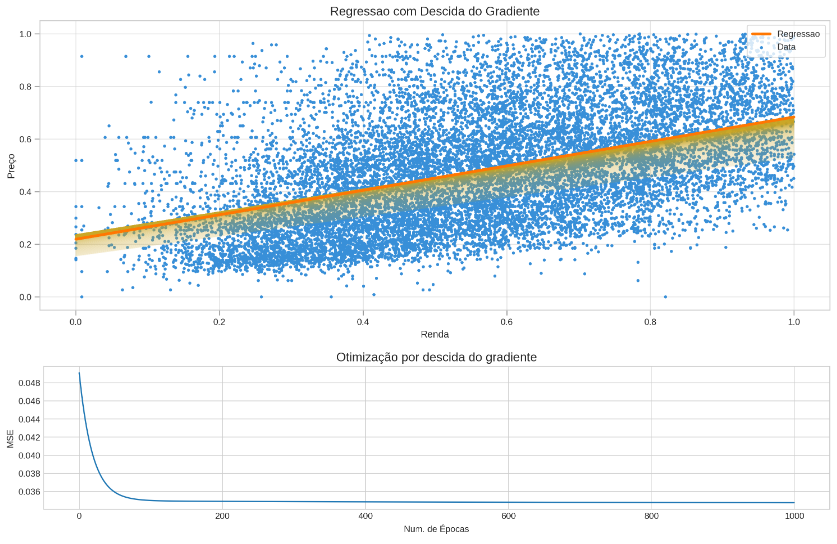

### **ToDo**: Discussão (10pt)

Use a função gradient_descent, para o conjunto de dados de casas ($X$ e $y$) carregados acima, com uma taxa de aprendizado de 0.01 por 1000 épocas. Analise as curvas plotadas. O que você pode dizer sobre as curvas?

```
  Pela implementação feita, pode-se afirmar que em poucas épocas (menos que 10) o MSE tende a 0.0346, consequentemente a reta da regressão logística em poucas iterações se aproxima do resultado esperado, ou seja, é encontrada, rapidamente, a equação da reta que melhor divide os dados da base.
```

### **ToDo**: Descida do Gradiente Estocástica (40pt)

A descida do gradiente estocástica (do inglês Stochastic Gradient Descent - SGD) tem este nome por que ela não é realizada no conjunto de dados inteiro, mas em uma sub-amostragem do conjunto de dados. Esta sub-amostragem é aleatória. Na SGD, o gradiente é aplicado a um sub-conjunto dos dados (um lote ou mini-lote). 

A função deve seguir:

  1.   Inicializar m e b aleatoriamente (entre 0 e 1)
  2.   Iterar por um número de épocas
  3.   A cada iteração, amostrar um mini-lote (sub-conjunto) de $X$ (*batch_size*),  calcular o valor predito para o mini-lote, calcular o erro quadrático para o mini-lote (entre valor predito e $y$), atualizar os valores de m e b, no sentido contrário do gradiente (o ajuste deve ser controlado por um taxa de aprendizado - *lr*).
  4.   Armazenar m, b e erro corrente para análise futura

0.7862398577303547

In [56]:
def SGD(X, y, lr=0.05, epoch=10, batch_size=1):
        
    '''
    Descida do Gradiente Estocástica
    '''
    
    m, b = 0.002, 0.5 # inicializa os parâmatros 
    log, mse_log = [], [] # listas para armazenar o processo de aprendizado
    
    for _ in range(epoch):
        
        # ToDo : amostre aleatoriamnte algumas instâncias (até batch_size)
        
        indices = [np.random.randint(len(X)) for i in range(batch_size)]
        mini_batch_X = np.asarray([X[i] for i in indices]) # ToDo : complete
        mini_batch_y = np.asarray([y[i] for i in indices]) # ToDo : complete
        N = len(mini_batch_X)

        predict = m*mini_batch_X + b # ToDo : propague (feed-forward) ara obter as predições : m* mini_batch_X + b

        MSE = (1/N)*(sum((mini_batch_y-predict)**2)) # ToDo : complete
        
        f = (1/N)*(sum((mini_batch_y-(m*mini_batch_X +b ))**2)) # ToDo : compute a derivada do mini-lote
        
        # Updating parameters m and b
        m -= (1/N)*(sum((-2)*mini_batch_X*(mini_batch_y-(m*mini_batch_X +b )))) # ToDo : atualize m com base na equação acima. Lembre-se de ponderar pela taxa de aprendizado (lr)
        b -= (1/N)*(sum((-2)*(mini_batch_y-(m*mini_batch_X +b )))) # ToDo : atualize b com base na equação acima. Lembre-se de ponderar pela taxa de aprendizado (lr)

        log.append((m, b))
        mse_log.append(MSE)      
    
    return m, b, log, mse_log

Use a função SGD, para o conjunto de dados de casas ($X$ e $y$) carregados acima, com uma taxa de aprendizado de 0.01 por 1000 épocas.

MSE: 0.03837529294213954


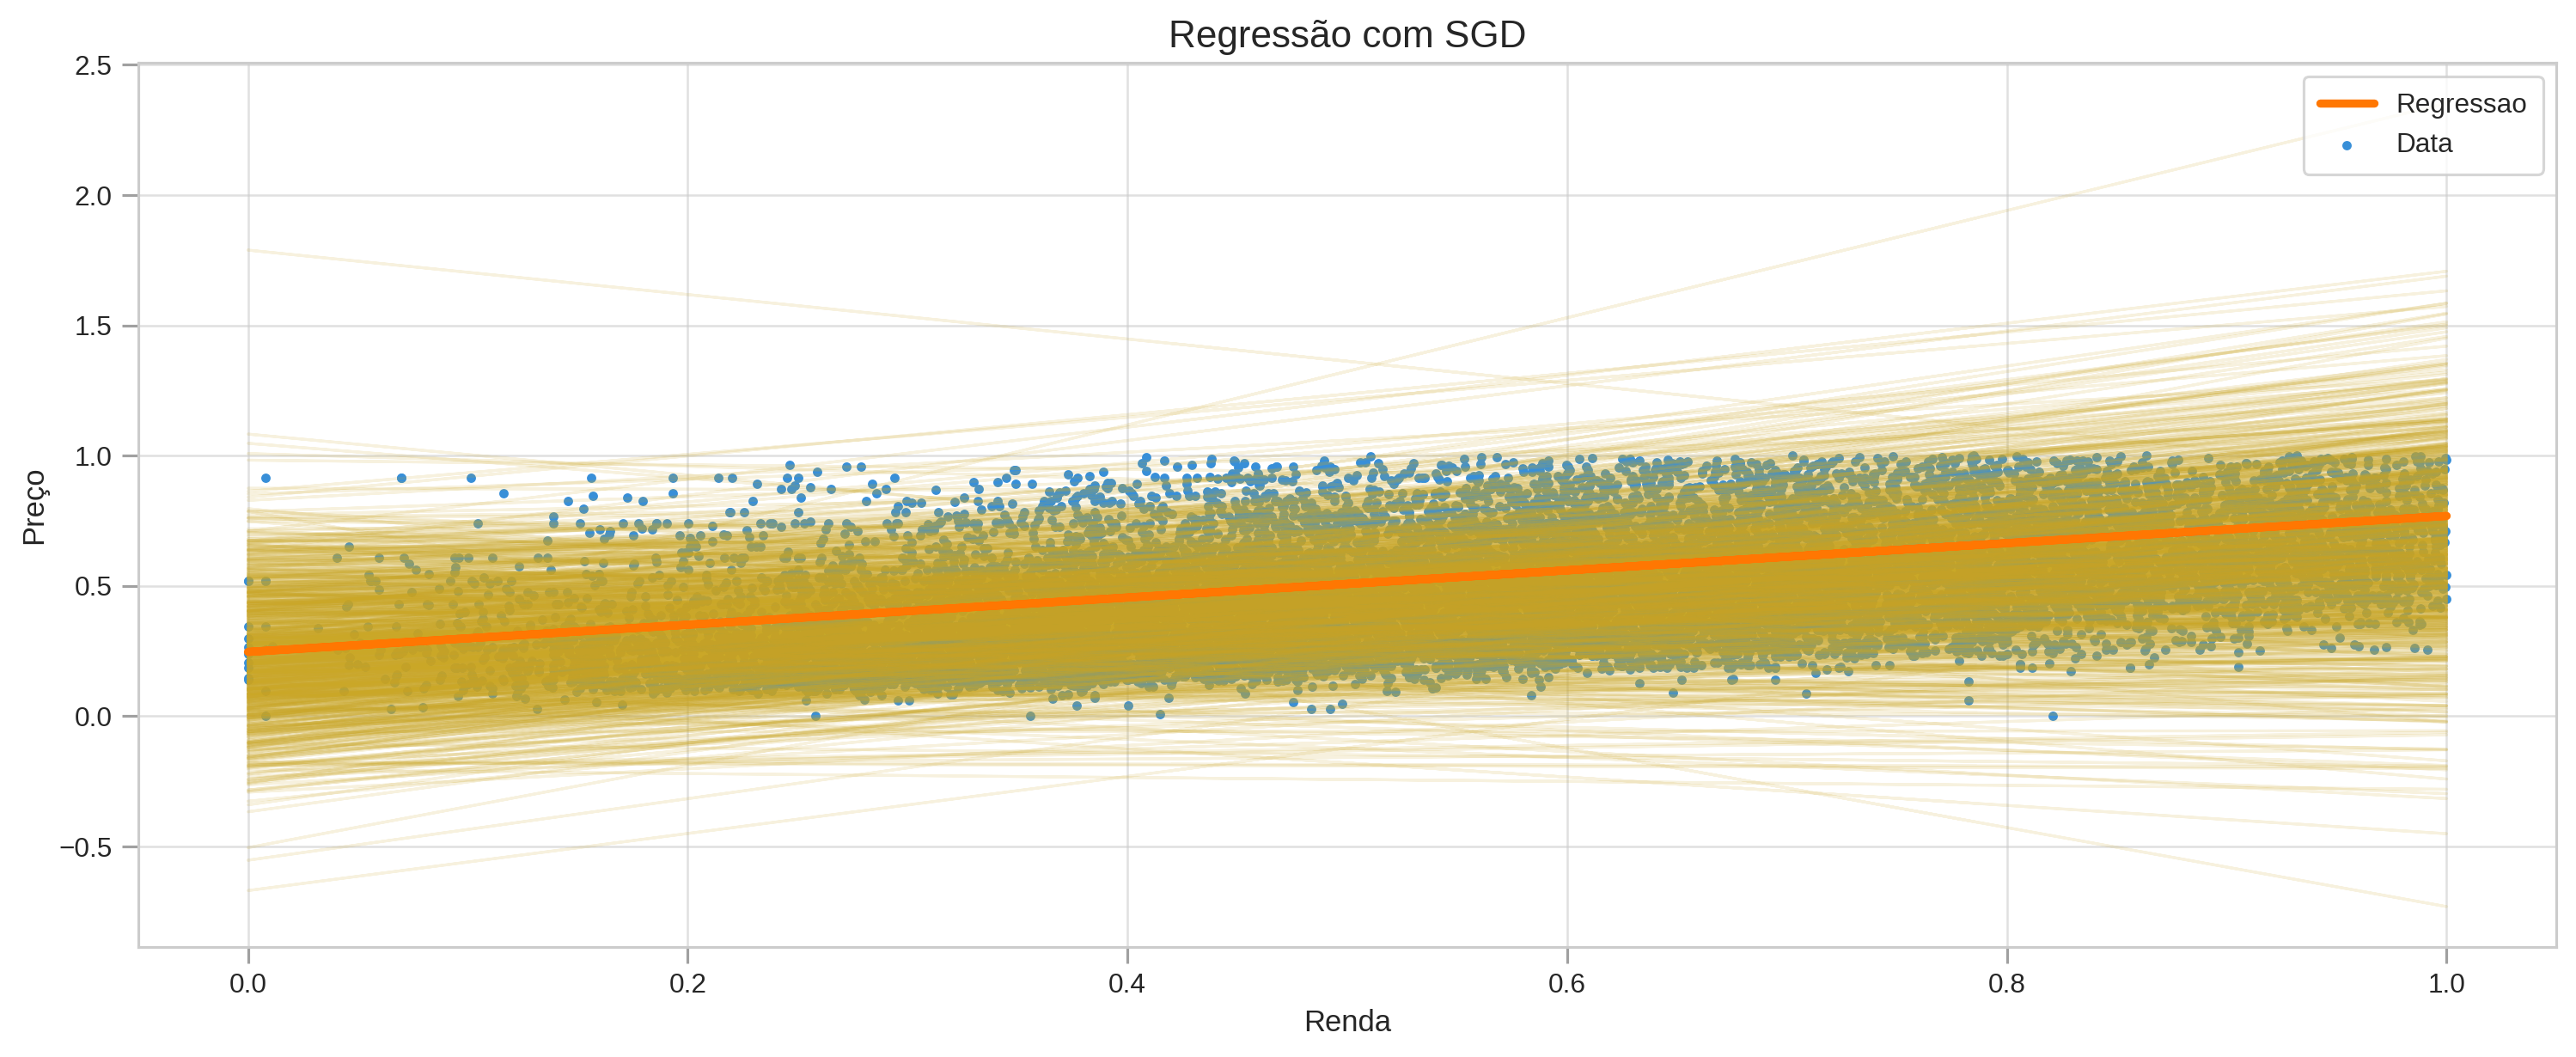

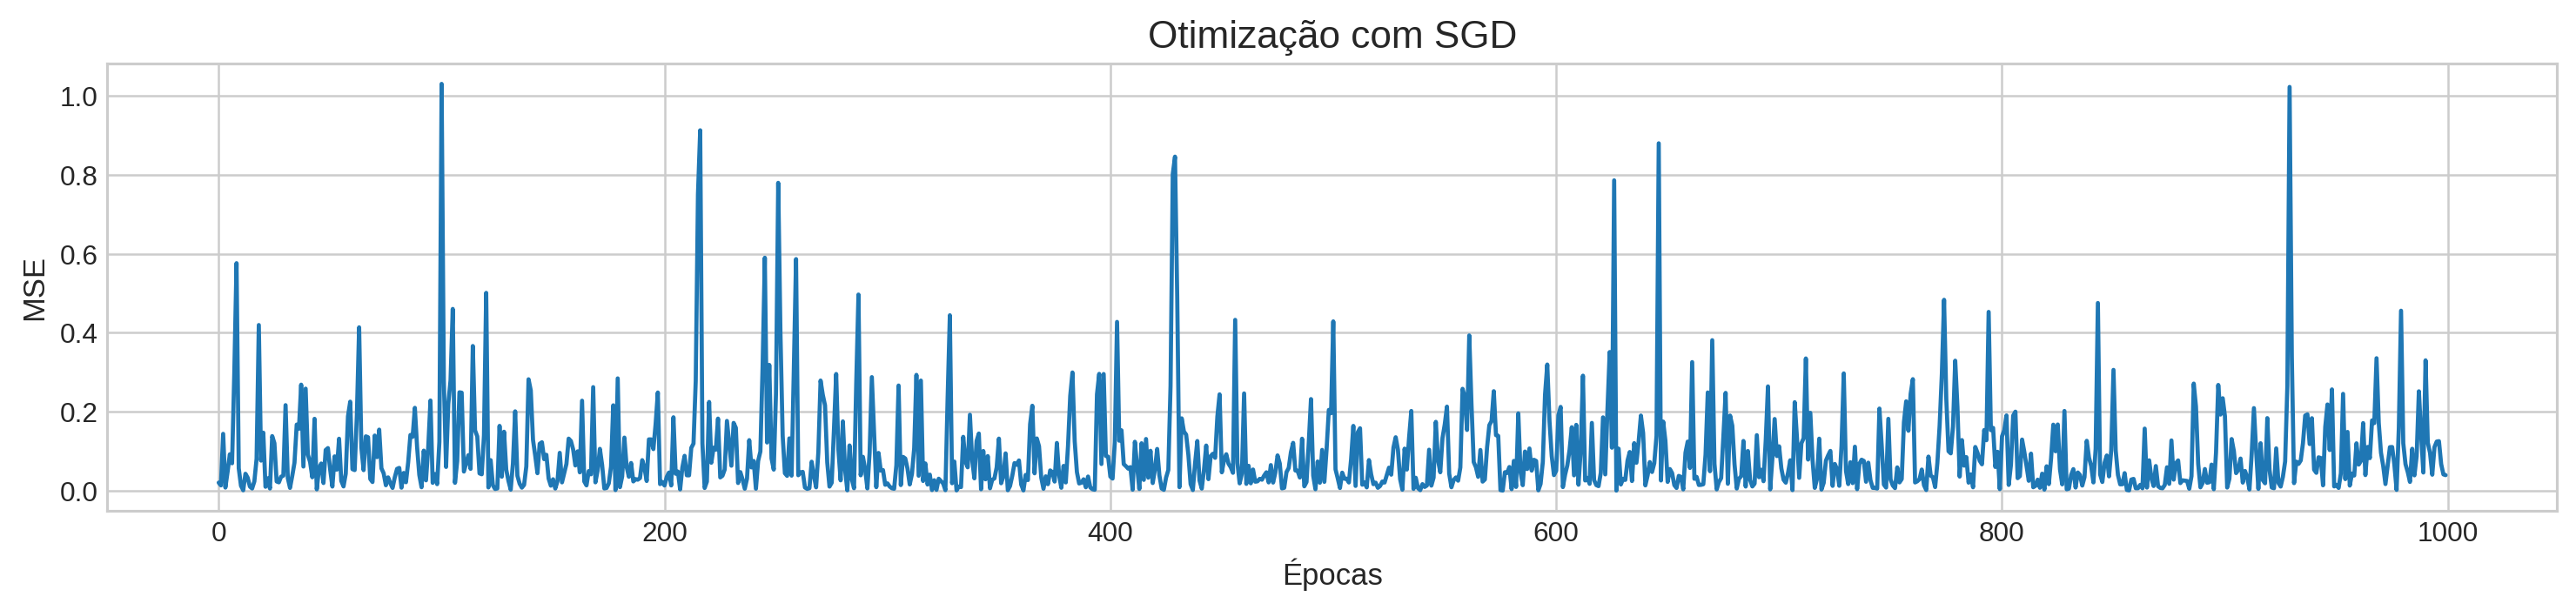

In [57]:
m, b, log2, mse2 = SGD(X, y, lr=0.01, epoch=1000, batch_size=2)

y_pred = m*X + b

print("MSE:",mean_squared_error(y, y_pred))
plot_regression(X, y, y_pred, log=log2, title="Regressão com SGD")

plt.figure(figsize=(16,3))
plt.rcParams['figure.dpi'] = 227
plt.plot(range(len(mse2)), mse2)
plt.title('Otimização com SGD', fontSize=14)
plt.xlabel('Épocas', fontSize=11)
plt.ylabel('MSE', fontSize=11)
plt.show()

**Resultado esperado (não precisa ser idêntico)**

```
 MSE: 0.03760346179860297
```

### **ToDo**: Discussão (10pt)

O que você conclui, olhando para as duas curvas de custo (MSE x Épocas) ?

```
  É possível concluir que utilizando a descida do gradiente estocástica também é possível convergir para a reta da regressão desejada (que divide melhor os dados), no entanto, o MSE varia muito com o passar das épocas por conta da aleatoriedade dos mini batches, isso faz com que demore um pouco mais para convergir ao resultado esperado, no entanto ajuda escapar de mínimos locais em situações específicas.
```